In [1]:
# !conda install -y pytorch-cuda=11.6 -c pytorch -c nvidia
# !python -c "import torch; print(torch.version.cuda)" 
# !conda info --envs
# !find /home/shashank/.conda/envs/RA_work -name libcusparse.so.11
# !export LD_LIBRARY_PATH="/home/shashank/.conda/envs/RA_work/lib:$LD_LIBRARY_PATH"
# !source ~/.bashrc
# !nvcc --version
# !conda install pyg -c pyg
# !python -c "import torch; print(torch.__version__)"
# !python --version
# !module avail
# !module load pytorch/1.10.1_py3.9
# !pip install torch_geometric
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install typing_extensions==4.7.1 --upgrade
# !pip install torch
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.7.0+cu118.html
# !pip install torch_geometric
# !pip install torch==2.7.0
# !pip install --upgrade typing-extensions

In [2]:
import torch
import numpy as np
import pandas as pd
import math
import random
import torch_geometric.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import HeteroData
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear
from sklearn.metrics import precision_recall_curve, auc
from torch_geometric.explain import Explainer, CaptumExplainer

In [4]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")
seed_everything(42)

Random seed set as 42


In [5]:
device = 'cuda:0'
feature_index = 0

In [6]:
# best_config = {'lr': 0.001,
#  'weight_decay': 0.005,
#  'epochs': 200,
#  'train_ratio': 0.8,
#  'val_ratio': 0.1,
#  'test_ratio': 0.1,
#  'hidden_channels': 64,
#  'num_heads': 4,
#  'num_layers': 2}

In [7]:
config = dict()
config["lr"] = 0.001
config["weight_decay"] = 5e-3
config["epochs"] = 1
config['train_ratio'] = 0.8
config['val_ratio'] = 0.1
config['test_ratio'] = 0.1
config['hidden_channels'] = 64
config['num_heads'] = 4
config['num_layers'] = 2
config

{'lr': 0.001,
 'weight_decay': 0.005,
 'epochs': 1,
 'train_ratio': 0.8,
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'hidden_channels': 64,
 'num_heads': 4,
 'num_layers': 2}

### Loading everything

In [8]:
patient_features = torch.tensor(np.load('data/Processed/patient_features.npy')).to(torch.float32)
procedure_features = torch.tensor(np.load('data/Processed/procedure_features.npy')).to(torch.float32)
medication_features = torch.tensor(np.load('data/Processed/medication_features.npy')).to(torch.float32)
lab_features = torch.tensor(np.load('data/Processed/lab_features.npy')).to(torch.float32)

patient_edges = torch.tensor(np.load('data/Processed/patient_edges.npy'))
procedure_edges = torch.tensor(np.load('data/Processed/procedures_edges.npy'))
medication_edges = torch.tensor(np.load('data/Processed/medication_edges.npy'))
lab_edges = torch.tensor(np.load('data/Processed/lab_edges.npy'))

labels = torch.tensor(np.load('data/Processed/MIMIC_y.npy')[:, feature_index]).to(torch.float32)

In [9]:
num_patient_nodes = len(patient_features)
num_train_nodes = int(config['train_ratio'] * num_patient_nodes)
num_val_nodes = int(config['val_ratio'] * num_patient_nodes)
num_test_nodes = num_patient_nodes - num_train_nodes - num_val_nodes

# patient_nodes_indices = torch.arange(num_patient_nodes)
# shuffled_indices = torch.randperm(num_patient_nodes)

patient_nodes_indices = np.arange(num_patient_nodes)
np.random.shuffle(patient_nodes_indices)
shuffled_indices = torch.tensor(patient_nodes_indices)

train_indices = shuffled_indices[:num_train_nodes]
val_indices = shuffled_indices[num_train_nodes:num_train_nodes + num_val_nodes]
test_indices = shuffled_indices[num_train_nodes + num_val_nodes:]

train_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)

train_mask[patient_nodes_indices[train_indices]] = True
val_mask[patient_nodes_indices[val_indices]] = True
test_mask[patient_nodes_indices[test_indices]] = True

print(len(train_mask), train_mask[:10])
print(len(val_mask), val_mask[:10])
print(len(test_mask), test_mask[:10])

1483 tensor([False, False,  True,  True,  True,  True,  True,  True,  True, False])
1483 tensor([ True,  True, False, False, False, False, False, False, False,  True])
1483 tensor([False, False, False, False, False, False, False, False, False, False])


In [10]:
data = HeteroData()

data['patient'].x = patient_features
data['patient'].y = labels
data['patient'].train_mask = train_mask
data['patient'].val_mask = val_mask
data['patient'].test_mask = test_mask
data['procedure'].x = procedure_features
data['medication'].x = medication_features
data['lab'].x = lab_features

data['patient', 'same_patient', 'patient'].edge_index = patient_edges
data['patient', 'proc_values', 'procedure'].edge_index = procedure_edges
data['patient', 'med_values', 'medication'].edge_index = medication_edges
data['patient', 'lab_values', 'lab'].edge_index = lab_edges

data = T.ToUndirected()(data)
# data = T.AddSelfLoops()(data)
# data = T.NormalizeFeatures()(data)

data = data.to(device)

print(data.has_isolated_nodes(), data.has_self_loops(), data.is_undirected())

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [9]:
print(len(procedure_features))
print(len(medication_features))
print(len(lab_features))

93
277
1051


In [10]:
class HGT(torch.nn.Module):
    
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, num_pat, num_proc, num_med, num_lab):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
#         for node_type in data.node_types:
#             self.lin_dict[node_type] = Linear(-1, hidden_channels)
        self.lin_dict["patient"] = Linear(num_pat, hidden_channels)
        self.lin_dict["procedure"] = Linear(num_proc, hidden_channels)
        self.lin_dict["medication"] = Linear(num_med, hidden_channels)
        self.lin_dict["lab"] = Linear(num_lab, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        out = self.lin(x_dict['patient'])
        out = F.sigmoid(out)
        return out

model = HGT(hidden_channels=64, out_channels=1, num_heads=2, num_layers=2, 
            num_pat=3, num_proc=len(procedure_features), num_med=len(medication_features), 
            num_lab=len(lab_features)).to(device)
print(model)

HGT(
  (lin_dict): ModuleDict(
    (patient): Linear(3, 64, bias=True)
    (procedure): Linear(93, 64, bias=True)
    (medication): Linear(277, 64, bias=True)
    (lab): Linear(1051, 64, bias=True)
  )
  (convs): ModuleList(
    (0): HGTConv(64, heads=2)
    (1): HGTConv(64, heads=2)
  )
  (lin): Linear(64, 1, bias=True)
)


In [24]:
losses = []
auprc_val = []
auprc_test = []
auprc_train = []
acc_val = []
acc_test = []
acc_train = []

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['patient'].train_mask
#     print(out[mask].squeeze()[:2], data['patient'].y[mask][:2])
    for index, value in enumerate(data['patient'].y[mask].long()):
        if value not in [0, 1]:
            print(index, value)
    
    criterion = torch.nn.BCELoss()
    loss = criterion(out[mask].squeeze(), data['patient'].y[mask])
    loss.backward()
    optimizer.step()
    train_acc = ((out[mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[mask].detach().cpu().numpy()).sum()/len(out[mask])
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[mask].cpu().numpy(), out[mask].squeeze().detach().cpu().numpy())
    train_auprc = auc(recall, precision)
    return train_acc, train_auprc, float(loss)

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    val_mask = data['patient'].val_mask
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[val_mask].cpu().numpy(), out[val_mask].squeeze().detach().cpu().numpy())
    val_auprc = auc(recall, precision)
    test_mask = data['patient'].test_mask
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[test_mask].cpu().numpy(), out[test_mask].squeeze().detach().cpu().numpy())
    test_auprc = auc(recall, precision)
    val_acc = ((out[val_mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[val_mask].detach().cpu().numpy()).sum()/len(out[val_mask])
    test_acc = ((out[test_mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[test_mask].detach().cpu().numpy()).sum()/len(out[test_mask])
    return (val_auprc, test_auprc, val_acc, test_acc)


for epoch in range(1, config["epochs"]):
    train_acc, train_auprc, loss = train()
    val_auprc, test_auprc, val_acc, test_acc = test()
    losses.append(loss)
    auprc_train.append(train_auprc)
    acc_train.append(train_acc)
    auprc_val.append(val_auprc)
    acc_val.append(val_acc)
    auprc_test.append(test_auprc)
    acc_test.append(test_acc)
    print(f'{epoch:03d}, Loss: {loss:.3f}, TrPRC: {train_auprc:.3f}, TrAcc: {train_acc:.3f}, VaPRC: {val_auprc:.3f}, VaAcc: {val_acc:.3f}, TePRC: {test_auprc:.3f}, TeAcc: {test_acc:.3f}')

/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


001, Loss: 0.837, TrPRC: 0.619, TrAcc: 0.385, VaPRC: 0.712, VaAcc: 0.662, TePRC: 0.629, TeAcc: 0.591


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


002, Loss: 0.861, TrPRC: 0.678, TrAcc: 0.615, VaPRC: 0.687, VaAcc: 0.655, TePRC: 0.620, TeAcc: 0.584


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


003, Loss: 0.721, TrPRC: 0.676, TrAcc: 0.606, VaPRC: 0.700, VaAcc: 0.628, TePRC: 0.637, TeAcc: 0.570


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


004, Loss: 0.671, TrPRC: 0.685, TrAcc: 0.593, VaPRC: 0.686, VaAcc: 0.554, TePRC: 0.639, TeAcc: 0.517


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


005, Loss: 0.671, TrPRC: 0.689, TrAcc: 0.542, VaPRC: 0.702, VaAcc: 0.493, TePRC: 0.649, TeAcc: 0.517


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


006, Loss: 0.677, TrPRC: 0.692, TrAcc: 0.544, VaPRC: 0.711, VaAcc: 0.507, TePRC: 0.655, TeAcc: 0.517


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


007, Loss: 0.675, TrPRC: 0.700, TrAcc: 0.543, VaPRC: 0.716, VaAcc: 0.574, TePRC: 0.660, TeAcc: 0.530


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


008, Loss: 0.667, TrPRC: 0.705, TrAcc: 0.555, VaPRC: 0.724, VaAcc: 0.642, TePRC: 0.658, TeAcc: 0.584


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


009, Loss: 0.658, TrPRC: 0.710, TrAcc: 0.605, VaPRC: 0.732, VaAcc: 0.662, TePRC: 0.668, TeAcc: 0.597


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


010, Loss: 0.653, TrPRC: 0.717, TrAcc: 0.614, VaPRC: 0.740, VaAcc: 0.669, TePRC: 0.675, TeAcc: 0.597


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


011, Loss: 0.656, TrPRC: 0.723, TrAcc: 0.621, VaPRC: 0.745, VaAcc: 0.669, TePRC: 0.682, TeAcc: 0.597


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


012, Loss: 0.656, TrPRC: 0.725, TrAcc: 0.621, VaPRC: 0.750, VaAcc: 0.669, TePRC: 0.687, TeAcc: 0.597


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


013, Loss: 0.650, TrPRC: 0.729, TrAcc: 0.621, VaPRC: 0.756, VaAcc: 0.669, TePRC: 0.700, TeAcc: 0.597


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


014, Loss: 0.645, TrPRC: 0.731, TrAcc: 0.621, VaPRC: 0.757, VaAcc: 0.669, TePRC: 0.712, TeAcc: 0.597


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


015, Loss: 0.645, TrPRC: 0.737, TrAcc: 0.622, VaPRC: 0.765, VaAcc: 0.676, TePRC: 0.726, TeAcc: 0.611


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


016, Loss: 0.645, TrPRC: 0.741, TrAcc: 0.625, VaPRC: 0.785, VaAcc: 0.689, TePRC: 0.740, TeAcc: 0.617


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


017, Loss: 0.642, TrPRC: 0.746, TrAcc: 0.631, VaPRC: 0.807, VaAcc: 0.696, TePRC: 0.742, TeAcc: 0.624


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


018, Loss: 0.638, TrPRC: 0.751, TrAcc: 0.636, VaPRC: 0.812, VaAcc: 0.696, TePRC: 0.745, TeAcc: 0.624


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


019, Loss: 0.635, TrPRC: 0.754, TrAcc: 0.637, VaPRC: 0.814, VaAcc: 0.696, TePRC: 0.746, TeAcc: 0.624


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


020, Loss: 0.634, TrPRC: 0.754, TrAcc: 0.637, VaPRC: 0.815, VaAcc: 0.696, TePRC: 0.751, TeAcc: 0.624


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


021, Loss: 0.632, TrPRC: 0.756, TrAcc: 0.637, VaPRC: 0.816, VaAcc: 0.696, TePRC: 0.758, TeAcc: 0.624


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


022, Loss: 0.628, TrPRC: 0.758, TrAcc: 0.636, VaPRC: 0.816, VaAcc: 0.689, TePRC: 0.768, TeAcc: 0.671


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


023, Loss: 0.625, TrPRC: 0.761, TrAcc: 0.656, VaPRC: 0.817, VaAcc: 0.655, TePRC: 0.772, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


024, Loss: 0.624, TrPRC: 0.762, TrAcc: 0.665, VaPRC: 0.824, VaAcc: 0.635, TePRC: 0.773, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


025, Loss: 0.622, TrPRC: 0.763, TrAcc: 0.670, VaPRC: 0.826, VaAcc: 0.662, TePRC: 0.775, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


026, Loss: 0.618, TrPRC: 0.764, TrAcc: 0.670, VaPRC: 0.830, VaAcc: 0.682, TePRC: 0.774, TeAcc: 0.685


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


027, Loss: 0.616, TrPRC: 0.764, TrAcc: 0.665, VaPRC: 0.833, VaAcc: 0.689, TePRC: 0.772, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


028, Loss: 0.615, TrPRC: 0.765, TrAcc: 0.661, VaPRC: 0.835, VaAcc: 0.682, TePRC: 0.775, TeAcc: 0.685


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


029, Loss: 0.613, TrPRC: 0.765, TrAcc: 0.669, VaPRC: 0.836, VaAcc: 0.649, TePRC: 0.781, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


030, Loss: 0.610, TrPRC: 0.767, TrAcc: 0.674, VaPRC: 0.841, VaAcc: 0.682, TePRC: 0.786, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


031, Loss: 0.609, TrPRC: 0.770, TrAcc: 0.690, VaPRC: 0.843, VaAcc: 0.689, TePRC: 0.785, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


032, Loss: 0.609, TrPRC: 0.771, TrAcc: 0.692, VaPRC: 0.846, VaAcc: 0.709, TePRC: 0.784, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


033, Loss: 0.607, TrPRC: 0.771, TrAcc: 0.686, VaPRC: 0.847, VaAcc: 0.682, TePRC: 0.783, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


034, Loss: 0.606, TrPRC: 0.770, TrAcc: 0.686, VaPRC: 0.846, VaAcc: 0.682, TePRC: 0.775, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


035, Loss: 0.606, TrPRC: 0.771, TrAcc: 0.680, VaPRC: 0.852, VaAcc: 0.703, TePRC: 0.781, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


036, Loss: 0.605, TrPRC: 0.771, TrAcc: 0.686, VaPRC: 0.852, VaAcc: 0.696, TePRC: 0.781, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


037, Loss: 0.603, TrPRC: 0.771, TrAcc: 0.683, VaPRC: 0.849, VaAcc: 0.682, TePRC: 0.782, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


038, Loss: 0.603, TrPRC: 0.772, TrAcc: 0.685, VaPRC: 0.851, VaAcc: 0.676, TePRC: 0.789, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


039, Loss: 0.602, TrPRC: 0.772, TrAcc: 0.685, VaPRC: 0.851, VaAcc: 0.696, TePRC: 0.791, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


040, Loss: 0.601, TrPRC: 0.771, TrAcc: 0.689, VaPRC: 0.850, VaAcc: 0.682, TePRC: 0.789, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


041, Loss: 0.600, TrPRC: 0.773, TrAcc: 0.682, VaPRC: 0.845, VaAcc: 0.682, TePRC: 0.783, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


042, Loss: 0.598, TrPRC: 0.776, TrAcc: 0.689, VaPRC: 0.840, VaAcc: 0.669, TePRC: 0.786, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


043, Loss: 0.598, TrPRC: 0.777, TrAcc: 0.696, VaPRC: 0.843, VaAcc: 0.676, TePRC: 0.790, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


044, Loss: 0.596, TrPRC: 0.777, TrAcc: 0.695, VaPRC: 0.845, VaAcc: 0.696, TePRC: 0.789, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


045, Loss: 0.596, TrPRC: 0.778, TrAcc: 0.696, VaPRC: 0.845, VaAcc: 0.689, TePRC: 0.793, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


046, Loss: 0.595, TrPRC: 0.780, TrAcc: 0.698, VaPRC: 0.853, VaAcc: 0.689, TePRC: 0.797, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


047, Loss: 0.594, TrPRC: 0.780, TrAcc: 0.699, VaPRC: 0.858, VaAcc: 0.696, TePRC: 0.799, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


048, Loss: 0.594, TrPRC: 0.781, TrAcc: 0.697, VaPRC: 0.857, VaAcc: 0.689, TePRC: 0.799, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


049, Loss: 0.593, TrPRC: 0.782, TrAcc: 0.696, VaPRC: 0.853, VaAcc: 0.689, TePRC: 0.788, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


050, Loss: 0.591, TrPRC: 0.784, TrAcc: 0.699, VaPRC: 0.848, VaAcc: 0.696, TePRC: 0.784, TeAcc: 0.685


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


051, Loss: 0.591, TrPRC: 0.786, TrAcc: 0.699, VaPRC: 0.848, VaAcc: 0.689, TePRC: 0.784, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


052, Loss: 0.590, TrPRC: 0.786, TrAcc: 0.701, VaPRC: 0.849, VaAcc: 0.689, TePRC: 0.784, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


053, Loss: 0.589, TrPRC: 0.787, TrAcc: 0.702, VaPRC: 0.851, VaAcc: 0.669, TePRC: 0.782, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


054, Loss: 0.588, TrPRC: 0.790, TrAcc: 0.699, VaPRC: 0.853, VaAcc: 0.669, TePRC: 0.783, TeAcc: 0.685


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


055, Loss: 0.587, TrPRC: 0.792, TrAcc: 0.699, VaPRC: 0.857, VaAcc: 0.669, TePRC: 0.781, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


056, Loss: 0.586, TrPRC: 0.794, TrAcc: 0.702, VaPRC: 0.852, VaAcc: 0.669, TePRC: 0.775, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


057, Loss: 0.585, TrPRC: 0.796, TrAcc: 0.699, VaPRC: 0.856, VaAcc: 0.669, TePRC: 0.778, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


058, Loss: 0.585, TrPRC: 0.796, TrAcc: 0.709, VaPRC: 0.845, VaAcc: 0.628, TePRC: 0.768, TeAcc: 0.685


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


059, Loss: 0.586, TrPRC: 0.798, TrAcc: 0.695, VaPRC: 0.866, VaAcc: 0.682, TePRC: 0.795, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


060, Loss: 0.588, TrPRC: 0.797, TrAcc: 0.703, VaPRC: 0.861, VaAcc: 0.676, TePRC: 0.792, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


061, Loss: 0.584, TrPRC: 0.797, TrAcc: 0.696, VaPRC: 0.844, VaAcc: 0.642, TePRC: 0.785, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


062, Loss: 0.585, TrPRC: 0.799, TrAcc: 0.696, VaPRC: 0.844, VaAcc: 0.649, TePRC: 0.787, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


063, Loss: 0.580, TrPRC: 0.799, TrAcc: 0.695, VaPRC: 0.848, VaAcc: 0.676, TePRC: 0.790, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


064, Loss: 0.582, TrPRC: 0.798, TrAcc: 0.712, VaPRC: 0.845, VaAcc: 0.655, TePRC: 0.777, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


065, Loss: 0.579, TrPRC: 0.803, TrAcc: 0.698, VaPRC: 0.856, VaAcc: 0.662, TePRC: 0.781, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


066, Loss: 0.577, TrPRC: 0.806, TrAcc: 0.701, VaPRC: 0.863, VaAcc: 0.682, TePRC: 0.791, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


067, Loss: 0.576, TrPRC: 0.806, TrAcc: 0.711, VaPRC: 0.864, VaAcc: 0.682, TePRC: 0.793, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


068, Loss: 0.575, TrPRC: 0.806, TrAcc: 0.716, VaPRC: 0.860, VaAcc: 0.649, TePRC: 0.785, TeAcc: 0.671


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


069, Loss: 0.573, TrPRC: 0.809, TrAcc: 0.717, VaPRC: 0.855, VaAcc: 0.649, TePRC: 0.779, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


070, Loss: 0.571, TrPRC: 0.809, TrAcc: 0.712, VaPRC: 0.853, VaAcc: 0.655, TePRC: 0.789, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


071, Loss: 0.569, TrPRC: 0.809, TrAcc: 0.711, VaPRC: 0.849, VaAcc: 0.635, TePRC: 0.791, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


072, Loss: 0.567, TrPRC: 0.813, TrAcc: 0.709, VaPRC: 0.853, VaAcc: 0.662, TePRC: 0.794, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


073, Loss: 0.564, TrPRC: 0.816, TrAcc: 0.714, VaPRC: 0.855, VaAcc: 0.662, TePRC: 0.790, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


074, Loss: 0.561, TrPRC: 0.818, TrAcc: 0.717, VaPRC: 0.853, VaAcc: 0.655, TePRC: 0.785, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


075, Loss: 0.557, TrPRC: 0.821, TrAcc: 0.712, VaPRC: 0.859, VaAcc: 0.676, TePRC: 0.792, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


076, Loss: 0.555, TrPRC: 0.823, TrAcc: 0.728, VaPRC: 0.841, VaAcc: 0.635, TePRC: 0.748, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


077, Loss: 0.569, TrPRC: 0.821, TrAcc: 0.709, VaPRC: 0.865, VaAcc: 0.730, TePRC: 0.804, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


078, Loss: 0.577, TrPRC: 0.821, TrAcc: 0.721, VaPRC: 0.869, VaAcc: 0.696, TePRC: 0.803, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


079, Loss: 0.559, TrPRC: 0.822, TrAcc: 0.719, VaPRC: 0.865, VaAcc: 0.669, TePRC: 0.796, TeAcc: 0.685


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


080, Loss: 0.566, TrPRC: 0.830, TrAcc: 0.697, VaPRC: 0.854, VaAcc: 0.689, TePRC: 0.782, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


081, Loss: 0.550, TrPRC: 0.831, TrAcc: 0.717, VaPRC: 0.849, VaAcc: 0.662, TePRC: 0.773, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


082, Loss: 0.549, TrPRC: 0.831, TrAcc: 0.745, VaPRC: 0.850, VaAcc: 0.689, TePRC: 0.770, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


083, Loss: 0.551, TrPRC: 0.834, TrAcc: 0.744, VaPRC: 0.851, VaAcc: 0.676, TePRC: 0.765, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


084, Loss: 0.538, TrPRC: 0.840, TrAcc: 0.750, VaPRC: 0.861, VaAcc: 0.682, TePRC: 0.780, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


085, Loss: 0.533, TrPRC: 0.849, TrAcc: 0.745, VaPRC: 0.863, VaAcc: 0.709, TePRC: 0.796, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


086, Loss: 0.528, TrPRC: 0.852, TrAcc: 0.742, VaPRC: 0.864, VaAcc: 0.716, TePRC: 0.807, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


087, Loss: 0.519, TrPRC: 0.857, TrAcc: 0.750, VaPRC: 0.859, VaAcc: 0.676, TePRC: 0.795, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


088, Loss: 0.514, TrPRC: 0.856, TrAcc: 0.755, VaPRC: 0.857, VaAcc: 0.689, TePRC: 0.793, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


089, Loss: 0.507, TrPRC: 0.860, TrAcc: 0.761, VaPRC: 0.864, VaAcc: 0.716, TePRC: 0.809, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


090, Loss: 0.499, TrPRC: 0.871, TrAcc: 0.764, VaPRC: 0.862, VaAcc: 0.676, TePRC: 0.794, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


091, Loss: 0.497, TrPRC: 0.875, TrAcc: 0.752, VaPRC: 0.862, VaAcc: 0.723, TePRC: 0.797, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


092, Loss: 0.496, TrPRC: 0.877, TrAcc: 0.787, VaPRC: 0.848, VaAcc: 0.676, TePRC: 0.756, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


093, Loss: 0.498, TrPRC: 0.866, TrAcc: 0.784, VaPRC: 0.846, VaAcc: 0.689, TePRC: 0.794, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


094, Loss: 0.477, TrPRC: 0.887, TrAcc: 0.797, VaPRC: 0.838, VaAcc: 0.696, TePRC: 0.792, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


095, Loss: 0.471, TrPRC: 0.889, TrAcc: 0.797, VaPRC: 0.831, VaAcc: 0.669, TePRC: 0.786, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


096, Loss: 0.469, TrPRC: 0.892, TrAcc: 0.785, VaPRC: 0.836, VaAcc: 0.676, TePRC: 0.797, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


097, Loss: 0.452, TrPRC: 0.899, TrAcc: 0.796, VaPRC: 0.837, VaAcc: 0.682, TePRC: 0.800, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


098, Loss: 0.451, TrPRC: 0.903, TrAcc: 0.810, VaPRC: 0.839, VaAcc: 0.682, TePRC: 0.800, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


099, Loss: 0.443, TrPRC: 0.905, TrAcc: 0.802, VaPRC: 0.840, VaAcc: 0.662, TePRC: 0.789, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


100, Loss: 0.438, TrPRC: 0.908, TrAcc: 0.800, VaPRC: 0.835, VaAcc: 0.682, TePRC: 0.807, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


101, Loss: 0.426, TrPRC: 0.912, TrAcc: 0.801, VaPRC: 0.835, VaAcc: 0.676, TePRC: 0.812, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


102, Loss: 0.421, TrPRC: 0.913, TrAcc: 0.806, VaPRC: 0.838, VaAcc: 0.676, TePRC: 0.799, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


103, Loss: 0.414, TrPRC: 0.912, TrAcc: 0.808, VaPRC: 0.837, VaAcc: 0.676, TePRC: 0.797, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


104, Loss: 0.407, TrPRC: 0.916, TrAcc: 0.818, VaPRC: 0.832, VaAcc: 0.696, TePRC: 0.811, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


105, Loss: 0.397, TrPRC: 0.926, TrAcc: 0.826, VaPRC: 0.836, VaAcc: 0.703, TePRC: 0.811, TeAcc: 0.752


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


106, Loss: 0.392, TrPRC: 0.929, TrAcc: 0.832, VaPRC: 0.829, VaAcc: 0.709, TePRC: 0.810, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


107, Loss: 0.385, TrPRC: 0.931, TrAcc: 0.834, VaPRC: 0.827, VaAcc: 0.709, TePRC: 0.807, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


108, Loss: 0.379, TrPRC: 0.933, TrAcc: 0.837, VaPRC: 0.828, VaAcc: 0.709, TePRC: 0.809, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


109, Loss: 0.372, TrPRC: 0.935, TrAcc: 0.835, VaPRC: 0.834, VaAcc: 0.682, TePRC: 0.811, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


110, Loss: 0.365, TrPRC: 0.939, TrAcc: 0.834, VaPRC: 0.839, VaAcc: 0.696, TePRC: 0.815, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


111, Loss: 0.359, TrPRC: 0.942, TrAcc: 0.846, VaPRC: 0.845, VaAcc: 0.709, TePRC: 0.814, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


112, Loss: 0.351, TrPRC: 0.944, TrAcc: 0.850, VaPRC: 0.852, VaAcc: 0.723, TePRC: 0.816, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


113, Loss: 0.343, TrPRC: 0.945, TrAcc: 0.852, VaPRC: 0.858, VaAcc: 0.730, TePRC: 0.826, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


114, Loss: 0.335, TrPRC: 0.949, TrAcc: 0.851, VaPRC: 0.861, VaAcc: 0.743, TePRC: 0.830, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


115, Loss: 0.327, TrPRC: 0.951, TrAcc: 0.856, VaPRC: 0.860, VaAcc: 0.736, TePRC: 0.828, TeAcc: 0.745


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


116, Loss: 0.318, TrPRC: 0.954, TrAcc: 0.864, VaPRC: 0.852, VaAcc: 0.723, TePRC: 0.830, TeAcc: 0.745


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


117, Loss: 0.308, TrPRC: 0.959, TrAcc: 0.875, VaPRC: 0.852, VaAcc: 0.730, TePRC: 0.834, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


118, Loss: 0.304, TrPRC: 0.960, TrAcc: 0.868, VaPRC: 0.847, VaAcc: 0.716, TePRC: 0.840, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


119, Loss: 0.296, TrPRC: 0.962, TrAcc: 0.879, VaPRC: 0.854, VaAcc: 0.703, TePRC: 0.824, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


120, Loss: 0.290, TrPRC: 0.964, TrAcc: 0.873, VaPRC: 0.850, VaAcc: 0.696, TePRC: 0.831, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


121, Loss: 0.273, TrPRC: 0.966, TrAcc: 0.879, VaPRC: 0.845, VaAcc: 0.730, TePRC: 0.826, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


122, Loss: 0.265, TrPRC: 0.970, TrAcc: 0.897, VaPRC: 0.851, VaAcc: 0.743, TePRC: 0.831, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


123, Loss: 0.281, TrPRC: 0.969, TrAcc: 0.883, VaPRC: 0.852, VaAcc: 0.736, TePRC: 0.829, TeAcc: 0.745


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


124, Loss: 0.246, TrPRC: 0.974, TrAcc: 0.908, VaPRC: 0.846, VaAcc: 0.689, TePRC: 0.822, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


125, Loss: 0.244, TrPRC: 0.973, TrAcc: 0.910, VaPRC: 0.859, VaAcc: 0.716, TePRC: 0.829, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


126, Loss: 0.281, TrPRC: 0.974, TrAcc: 0.873, VaPRC: 0.852, VaAcc: 0.750, TePRC: 0.809, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


127, Loss: 0.221, TrPRC: 0.980, TrAcc: 0.922, VaPRC: 0.861, VaAcc: 0.723, TePRC: 0.811, TeAcc: 0.698


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


128, Loss: 0.228, TrPRC: 0.981, TrAcc: 0.908, VaPRC: 0.863, VaAcc: 0.689, TePRC: 0.823, TeAcc: 0.678


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


129, Loss: 0.247, TrPRC: 0.975, TrAcc: 0.895, VaPRC: 0.862, VaAcc: 0.730, TePRC: 0.827, TeAcc: 0.691


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


130, Loss: 0.217, TrPRC: 0.979, TrAcc: 0.910, VaPRC: 0.856, VaAcc: 0.736, TePRC: 0.818, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


131, Loss: 0.223, TrPRC: 0.984, TrAcc: 0.912, VaPRC: 0.856, VaAcc: 0.757, TePRC: 0.806, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


132, Loss: 0.189, TrPRC: 0.984, TrAcc: 0.933, VaPRC: 0.862, VaAcc: 0.750, TePRC: 0.813, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


133, Loss: 0.199, TrPRC: 0.986, TrAcc: 0.925, VaPRC: 0.859, VaAcc: 0.784, TePRC: 0.815, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


134, Loss: 0.172, TrPRC: 0.987, TrAcc: 0.937, VaPRC: 0.868, VaAcc: 0.757, TePRC: 0.812, TeAcc: 0.711


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


135, Loss: 0.186, TrPRC: 0.987, TrAcc: 0.930, VaPRC: 0.870, VaAcc: 0.770, TePRC: 0.815, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


136, Loss: 0.162, TrPRC: 0.989, TrAcc: 0.939, VaPRC: 0.875, VaAcc: 0.784, TePRC: 0.819, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


137, Loss: 0.169, TrPRC: 0.990, TrAcc: 0.933, VaPRC: 0.875, VaAcc: 0.777, TePRC: 0.808, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


138, Loss: 0.148, TrPRC: 0.992, TrAcc: 0.953, VaPRC: 0.872, VaAcc: 0.784, TePRC: 0.804, TeAcc: 0.705


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


139, Loss: 0.147, TrPRC: 0.993, TrAcc: 0.950, VaPRC: 0.875, VaAcc: 0.791, TePRC: 0.813, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


140, Loss: 0.144, TrPRC: 0.992, TrAcc: 0.944, VaPRC: 0.874, VaAcc: 0.791, TePRC: 0.816, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


141, Loss: 0.135, TrPRC: 0.993, TrAcc: 0.954, VaPRC: 0.870, VaAcc: 0.784, TePRC: 0.809, TeAcc: 0.718


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


142, Loss: 0.132, TrPRC: 0.994, TrAcc: 0.953, VaPRC: 0.868, VaAcc: 0.784, TePRC: 0.813, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


143, Loss: 0.119, TrPRC: 0.995, TrAcc: 0.960, VaPRC: 0.865, VaAcc: 0.770, TePRC: 0.827, TeAcc: 0.725


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


144, Loss: 0.114, TrPRC: 0.995, TrAcc: 0.960, VaPRC: 0.865, VaAcc: 0.770, TePRC: 0.824, TeAcc: 0.732


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


145, Loss: 0.111, TrPRC: 0.996, TrAcc: 0.965, VaPRC: 0.866, VaAcc: 0.770, TePRC: 0.817, TeAcc: 0.752


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


146, Loss: 0.102, TrPRC: 0.996, TrAcc: 0.970, VaPRC: 0.866, VaAcc: 0.764, TePRC: 0.814, TeAcc: 0.752


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


147, Loss: 0.102, TrPRC: 0.996, TrAcc: 0.969, VaPRC: 0.863, VaAcc: 0.770, TePRC: 0.823, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


148, Loss: 0.097, TrPRC: 0.996, TrAcc: 0.969, VaPRC: 0.861, VaAcc: 0.777, TePRC: 0.832, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


149, Loss: 0.088, TrPRC: 0.997, TrAcc: 0.973, VaPRC: 0.865, VaAcc: 0.777, TePRC: 0.832, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


150, Loss: 0.088, TrPRC: 0.997, TrAcc: 0.974, VaPRC: 0.867, VaAcc: 0.818, TePRC: 0.826, TeAcc: 0.752


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


151, Loss: 0.089, TrPRC: 0.997, TrAcc: 0.974, VaPRC: 0.862, VaAcc: 0.804, TePRC: 0.837, TeAcc: 0.738


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


152, Loss: 0.092, TrPRC: 0.996, TrAcc: 0.972, VaPRC: 0.868, VaAcc: 0.818, TePRC: 0.836, TeAcc: 0.752


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


153, Loss: 0.079, TrPRC: 0.998, TrAcc: 0.977, VaPRC: 0.867, VaAcc: 0.804, TePRC: 0.824, TeAcc: 0.745


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


154, Loss: 0.092, TrPRC: 0.997, TrAcc: 0.966, VaPRC: 0.866, VaAcc: 0.824, TePRC: 0.837, TeAcc: 0.745


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


155, Loss: 0.111, TrPRC: 0.996, TrAcc: 0.957, VaPRC: 0.864, VaAcc: 0.824, TePRC: 0.834, TeAcc: 0.745


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


156, Loss: 0.097, TrPRC: 0.996, TrAcc: 0.966, VaPRC: 0.865, VaAcc: 0.811, TePRC: 0.818, TeAcc: 0.772


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


157, Loss: 0.101, TrPRC: 0.997, TrAcc: 0.962, VaPRC: 0.868, VaAcc: 0.811, TePRC: 0.828, TeAcc: 0.752


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


158, Loss: 0.074, TrPRC: 0.997, TrAcc: 0.976, VaPRC: 0.867, VaAcc: 0.824, TePRC: 0.835, TeAcc: 0.765


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


159, Loss: 0.085, TrPRC: 0.997, TrAcc: 0.969, VaPRC: 0.864, VaAcc: 0.804, TePRC: 0.832, TeAcc: 0.765


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


160, Loss: 0.069, TrPRC: 0.998, TrAcc: 0.975, VaPRC: 0.861, VaAcc: 0.804, TePRC: 0.822, TeAcc: 0.792


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


161, Loss: 0.083, TrPRC: 0.998, TrAcc: 0.970, VaPRC: 0.869, VaAcc: 0.838, TePRC: 0.826, TeAcc: 0.779


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


162, Loss: 0.071, TrPRC: 0.998, TrAcc: 0.976, VaPRC: 0.870, VaAcc: 0.838, TePRC: 0.822, TeAcc: 0.785


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


163, Loss: 0.104, TrPRC: 0.994, TrAcc: 0.969, VaPRC: 0.864, VaAcc: 0.824, TePRC: 0.811, TeAcc: 0.785


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


164, Loss: 0.066, TrPRC: 0.999, TrAcc: 0.978, VaPRC: 0.869, VaAcc: 0.811, TePRC: 0.815, TeAcc: 0.779


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


165, Loss: 0.107, TrPRC: 0.998, TrAcc: 0.960, VaPRC: 0.861, VaAcc: 0.824, TePRC: 0.818, TeAcc: 0.792


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


166, Loss: 0.064, TrPRC: 0.999, TrAcc: 0.977, VaPRC: 0.867, VaAcc: 0.838, TePRC: 0.824, TeAcc: 0.779


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


167, Loss: 0.068, TrPRC: 0.999, TrAcc: 0.976, VaPRC: 0.878, VaAcc: 0.838, TePRC: 0.819, TeAcc: 0.785


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


168, Loss: 0.060, TrPRC: 0.999, TrAcc: 0.982, VaPRC: 0.870, VaAcc: 0.811, TePRC: 0.816, TeAcc: 0.758


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


169, Loss: 0.072, TrPRC: 0.998, TrAcc: 0.974, VaPRC: 0.865, VaAcc: 0.824, TePRC: 0.836, TeAcc: 0.785


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


170, Loss: 0.056, TrPRC: 0.999, TrAcc: 0.981, VaPRC: 0.861, VaAcc: 0.818, TePRC: 0.846, TeAcc: 0.765


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


171, Loss: 0.065, TrPRC: 0.999, TrAcc: 0.976, VaPRC: 0.865, VaAcc: 0.818, TePRC: 0.841, TeAcc: 0.779


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


172, Loss: 0.052, TrPRC: 0.999, TrAcc: 0.979, VaPRC: 0.866, VaAcc: 0.824, TePRC: 0.825, TeAcc: 0.772


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


173, Loss: 0.051, TrPRC: 0.999, TrAcc: 0.986, VaPRC: 0.866, VaAcc: 0.838, TePRC: 0.813, TeAcc: 0.779


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


174, Loss: 0.056, TrPRC: 0.998, TrAcc: 0.983, VaPRC: 0.869, VaAcc: 0.818, TePRC: 0.811, TeAcc: 0.758


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


175, Loss: 0.043, TrPRC: 1.000, TrAcc: 0.987, VaPRC: 0.866, VaAcc: 0.824, TePRC: 0.817, TeAcc: 0.765


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


176, Loss: 0.046, TrPRC: 1.000, TrAcc: 0.984, VaPRC: 0.868, VaAcc: 0.824, TePRC: 0.807, TeAcc: 0.772


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


177, Loss: 0.038, TrPRC: 1.000, TrAcc: 0.987, VaPRC: 0.868, VaAcc: 0.838, TePRC: 0.804, TeAcc: 0.765


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


178, Loss: 0.040, TrPRC: 1.000, TrAcc: 0.987, VaPRC: 0.866, VaAcc: 0.838, TePRC: 0.806, TeAcc: 0.792


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


179, Loss: 0.035, TrPRC: 1.000, TrAcc: 0.989, VaPRC: 0.861, VaAcc: 0.818, TePRC: 0.820, TeAcc: 0.792


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


180, Loss: 0.034, TrPRC: 1.000, TrAcc: 0.990, VaPRC: 0.861, VaAcc: 0.818, TePRC: 0.823, TeAcc: 0.792


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


181, Loss: 0.035, TrPRC: 1.000, TrAcc: 0.987, VaPRC: 0.859, VaAcc: 0.804, TePRC: 0.818, TeAcc: 0.805


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


182, Loss: 0.032, TrPRC: 1.000, TrAcc: 0.989, VaPRC: 0.858, VaAcc: 0.811, TePRC: 0.817, TeAcc: 0.805


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


183, Loss: 0.033, TrPRC: 1.000, TrAcc: 0.987, VaPRC: 0.858, VaAcc: 0.818, TePRC: 0.816, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


184, Loss: 0.035, TrPRC: 1.000, TrAcc: 0.989, VaPRC: 0.855, VaAcc: 0.811, TePRC: 0.816, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


185, Loss: 0.029, TrPRC: 1.000, TrAcc: 0.990, VaPRC: 0.854, VaAcc: 0.811, TePRC: 0.817, TeAcc: 0.805


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


186, Loss: 0.030, TrPRC: 1.000, TrAcc: 0.990, VaPRC: 0.853, VaAcc: 0.804, TePRC: 0.813, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


187, Loss: 0.027, TrPRC: 1.000, TrAcc: 0.992, VaPRC: 0.858, VaAcc: 0.811, TePRC: 0.815, TeAcc: 0.812


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


188, Loss: 0.027, TrPRC: 1.000, TrAcc: 0.992, VaPRC: 0.858, VaAcc: 0.804, TePRC: 0.817, TeAcc: 0.805


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


189, Loss: 0.027, TrPRC: 1.000, TrAcc: 0.992, VaPRC: 0.858, VaAcc: 0.811, TePRC: 0.820, TeAcc: 0.812


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


190, Loss: 0.025, TrPRC: 1.000, TrAcc: 0.993, VaPRC: 0.857, VaAcc: 0.804, TePRC: 0.827, TeAcc: 0.805


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


191, Loss: 0.025, TrPRC: 1.000, TrAcc: 0.994, VaPRC: 0.855, VaAcc: 0.804, TePRC: 0.825, TeAcc: 0.812


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


192, Loss: 0.023, TrPRC: 1.000, TrAcc: 0.994, VaPRC: 0.857, VaAcc: 0.811, TePRC: 0.824, TeAcc: 0.812


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


193, Loss: 0.023, TrPRC: 1.000, TrAcc: 0.995, VaPRC: 0.856, VaAcc: 0.811, TePRC: 0.824, TeAcc: 0.812


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


194, Loss: 0.022, TrPRC: 1.000, TrAcc: 0.995, VaPRC: 0.854, VaAcc: 0.811, TePRC: 0.824, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


195, Loss: 0.021, TrPRC: 1.000, TrAcc: 0.993, VaPRC: 0.856, VaAcc: 0.804, TePRC: 0.827, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


196, Loss: 0.022, TrPRC: 1.000, TrAcc: 0.993, VaPRC: 0.855, VaAcc: 0.804, TePRC: 0.830, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


197, Loss: 0.021, TrPRC: 1.000, TrAcc: 0.993, VaPRC: 0.854, VaAcc: 0.804, TePRC: 0.828, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


198, Loss: 0.023, TrPRC: 1.000, TrAcc: 0.993, VaPRC: 0.858, VaAcc: 0.804, TePRC: 0.828, TeAcc: 0.819


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


199, Loss: 0.021, TrPRC: 1.000, TrAcc: 0.993, VaPRC: 0.858, VaAcc: 0.811, TePRC: 0.823, TeAcc: 0.805


/home/shashank/.conda/envs/RA_work/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


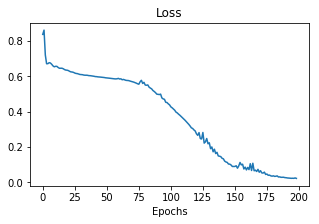

In [25]:
plt.figure(figsize=(5,3))
plt.title("Loss")
plt.xlabel("Epochs")
plt.plot(losses)
plt.show()

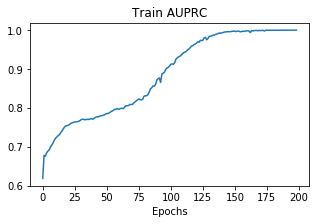

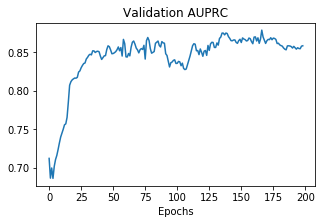

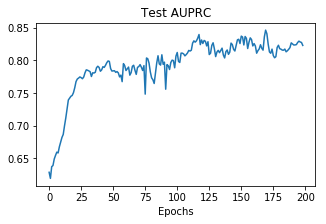

In [26]:
plt.figure(figsize=(5,3))
plt.title("Train AUPRC")
plt.plot(auprc_train)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Validation AUPRC")
plt.xlabel("Epochs")
plt.plot(auprc_val)
plt.show()

plt.figure(figsize=(5,3))
plt.title("Test AUPRC")
plt.xlabel("Epochs")
plt.plot(auprc_test)
plt.show()

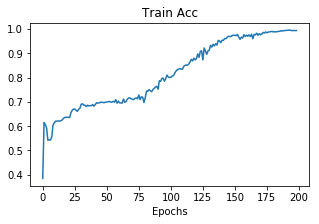

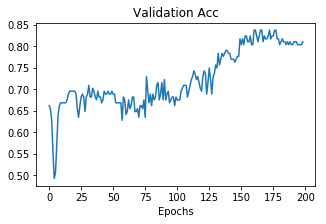

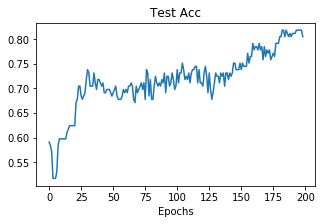

In [27]:
plt.figure(figsize=(5,3))
plt.title("Train Acc")
plt.plot(acc_train)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Validation Acc")
plt.plot(acc_val)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Test Acc")
plt.plot(acc_test)
plt.xlabel("Epochs")
plt.show()

## End